<a href="https://colab.research.google.com/github/chaitu2568/DEEP-LEARNING/blob/master/Image_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install torch torchvision
!pip install pillow==4.0.0

     |████████████████████████████████| 2.0MB 9.7MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.3.0 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 6.0.0
    Uninstalling Pillow-6.0.0:
      Successfully uninstalled Pillow-6.0.0


In [0]:
%matplotlib inline
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [0]:
vgg_model=models.vgg19(pretrained=True).features

#To stop the Back-Propagation
for parameter in vgg_model.parameters():
  parameter.requires_grad_(False)

  

In [21]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg_model.to(device)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def load_images(img_path,max_size=400,shape=None):
  image=Image.open(img_path).convert('RGB')
  if max(image.size)>max_size:
    size=max_size
  else:
    size=max(image.size)
    
  if shape is not None:
    size=shape
  transformations=transforms.Compose([
                  transforms.Resize(size),
                  transforms.ToTensor(),
                  transforms.Normalize((0.5,0.5,0.5),
                                        (0.5,0.5,0.5))
  ])
  image=transformations(image).unsqueeze(0)
  return image
  

In [0]:
content=load_images('content.jpg').to(device)
style=load_images('style.jpg',shape=content.shape[-2:]).to(device)

In [0]:
# Now to plot the graph covert back into Tensor

def img_convert(tensor):
#   first cloning and coverting into numpy array
  image=tensor.cpu().clone().detach().numpy()
#   changing dimensions from 1,28,28 to 28,28,1
  image=image.squeeze()
  image=image.transpose(1,2,0)  
#   deNormalizing it by multiplying with sd and adding mean
  image=image*np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5))
#   changing the range from 0 to 1
  image=image.clip(0,1)
  return image

(-0.5, 399.5, 399.5, -0.5)

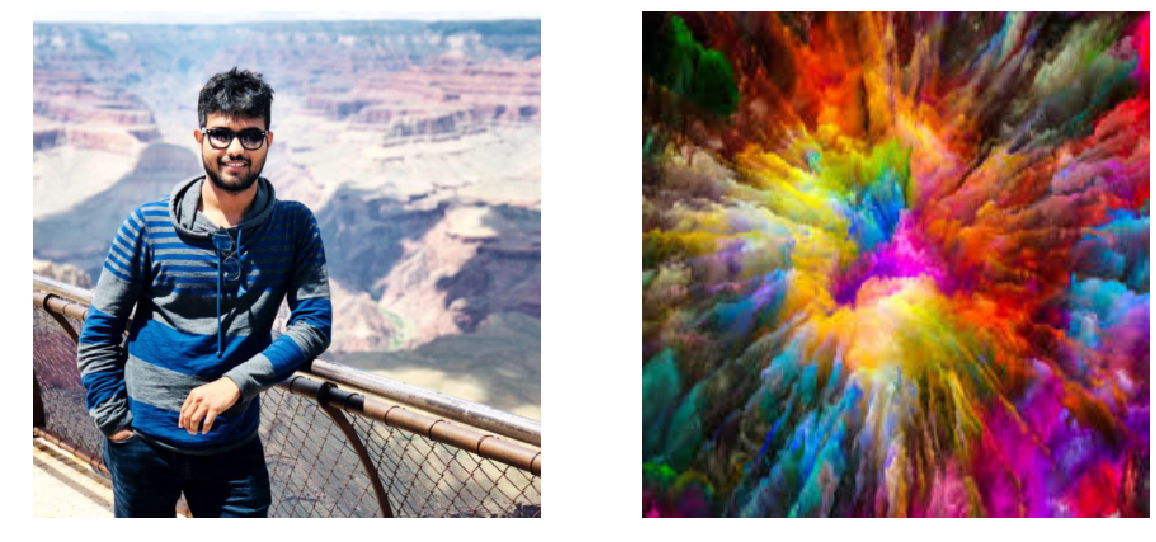

In [25]:
main_fig, (ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.imshow(img_convert(content))
ax1.axis('off')
ax2.imshow(img_convert(style))
ax2.axis('off')

In [0]:
def extract_features(image,model):
  features={}
  layers={
         '2':'con1_2',
         '7':'con2_2',
         '14':'con3_3',
         '23':'con4_3',
#         Content Extraction
         '25':'con4_4', 
         '32':'con5_3'
          
  }
  for name,layer in model._modules.items():
    image=layer(image)
    
    if name in layers:
      features[layers[name]]=image
  return features
      

In [0]:
content_features=extract_features(content,vgg_model)
style_features=extract_features(style,vgg_model)

In [0]:
def gram_matrix(tensor):
  _,d, h, w=tensor.size()
#   converting into 2 dimesional tensor
  tensor=tensor.view(d, h*w)
#  now making the dot product of tensor with its transpose
  gram=torch.mm(tensor,tensor.t())
  return gram

In [0]:
style_gram_dict={layer:gram_matrix(style_features[layer]) for layer in style_features}

In [0]:
style_weights={'con1_2':1.,
              'con2_2':0.75,
              'con3_3':0.2,
              'con4_3':0.2,
              'con5_3':0.2}
content_ratio=1
style_ratio=1e6

In [0]:
# Now we initialize the target Image by cloning the content image first and then adding several features of style image during optimization process
target=content.clone().requires_grad_(True).to(device)

In [0]:
show_image_every=300 #iterations
steps=2100
optimizer=optim.Adam([target],lr=0.003)
H,W,channels=img_convert(target).shape
#this contains the List of all the Images for each 300 Iterations
image_array=np.empty(shape=(300,H,W,channels))
#to capture the image Capture_Frame captures image for every 7 Steps
capture_frame=steps/300
counter=0


Epoch NUMBER: 300
Total Loss 8519192.0


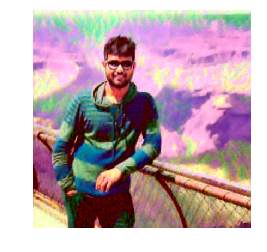

Epoch NUMBER: 600
Total Loss 2330845.75


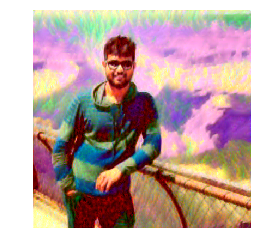

Epoch NUMBER: 900
Total Loss 1163396.375


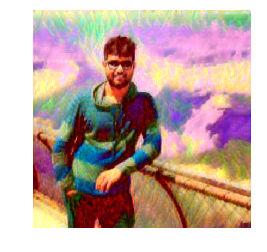

Epoch NUMBER: 1200
Total Loss 781324.75


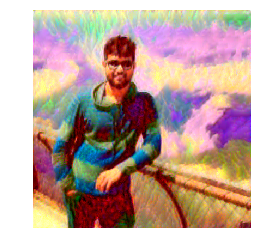

Epoch NUMBER: 1500
Total Loss 591918.875


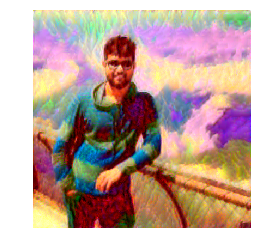

Epoch NUMBER: 1800
Total Loss 473517.6875


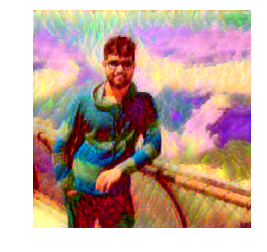

Epoch NUMBER: 2100
Total Loss 390013.78125


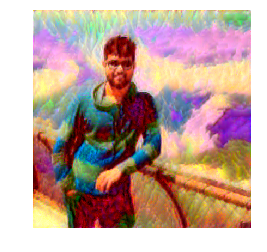

In [35]:
#Optimization step Which Includes calculatiing and Style and Content Loss for Target Image
for epoch in range(1,steps+1):
  target_features=extract_features(target,vgg_model)
  #Calculating Content Loss For the Target Image
  content_loss=torch.mean((target_features['con4_4']-content_features['con4_4'])**2)
  
  style_loss=0
  for layer in style_weights:
    target_feature=target_features[layer]
    target_gram=gram_matrix(target_feature)
    style_gram=style_gram_dict[layer]
    #This losses are Multiplied by their weights and Normalized
    style_layer_loss=style_weights[layer]*torch.mean((target_gram-style_gram)**2)
    _,d,h,w=target_feature.shape
    style_loss+=style_layer_loss/(d * h * w)
    
    
  final_loss=content_loss * content_ratio + style_loss * style_ratio
  #Now Again performing the Back-propagation to reduce the Final_loss by adding more Style Features to the Target Image
  optimizer.zero_grad()
  final_loss.backward()
  optimizer.step()
  
  if epoch % show_image_every ==0:
    print('Epoch NUMBER:',epoch)
    print('Total Loss',final_loss.item())
    plt.imshow(img_convert(target))
    plt.axis('off')
    plt.show()
    
  # This is to store Images for every frame to develop the video 
  if epoch % capture_frame ==0:
    image_array[counter]=img_convert(target)
    counter+=1
    
    
    

(-0.5, 399.5, 399.5, -0.5)

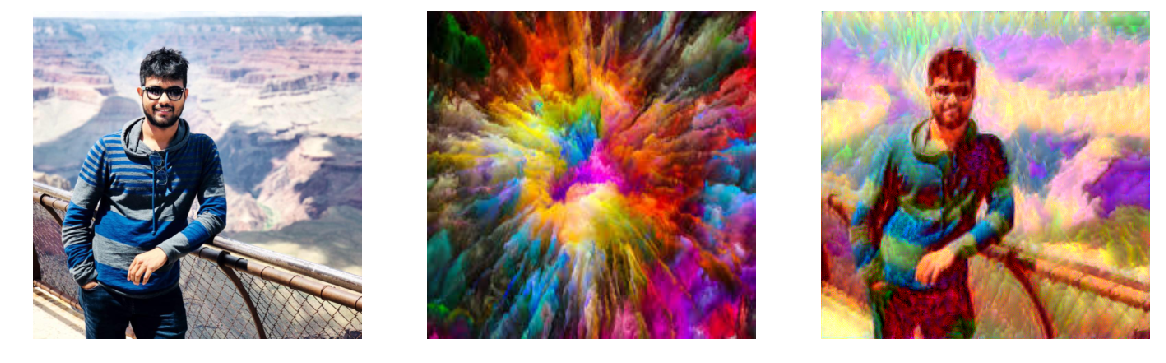

In [36]:
final, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,10))
ax1.imshow(img_convert(content))
ax1.axis('off')
ax2.imshow(img_convert(style))
ax2.axis('off')
ax3.imshow(img_convert(target))
ax3.axis('off')

In [0]:
#importing cv2 to playwith videos and Images
import cv2
# 30 frames per second
frame_height,frame_width,_=img_convert(target).shape
video=cv2.VideoWriter('mystyling.mp4',cv2.VideoWriter_fourcc(*'XVID'),30,(frame_height,frame_width))


for i in range(300):
  img=image_array[i]
  #to convert it into RGB image by de normalizing it
  img=img*255
  #this is the only the datatype accpeted by cv2
  img=np.array(img,dtype=np.uint8)
  #t convert it into BGR format to RGBformat
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  video.write(img)

In [0]:
from google.colab import files
files.download('mystyling.mp4')